In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np


In [2]:
train_data = datasets.FashionMNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
  target_transform=None
)

test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor()
)

In [3]:
img, target = train_data[0]
img.shape

torch.Size([1, 28, 28])

In [8]:
classes = train_data.classes

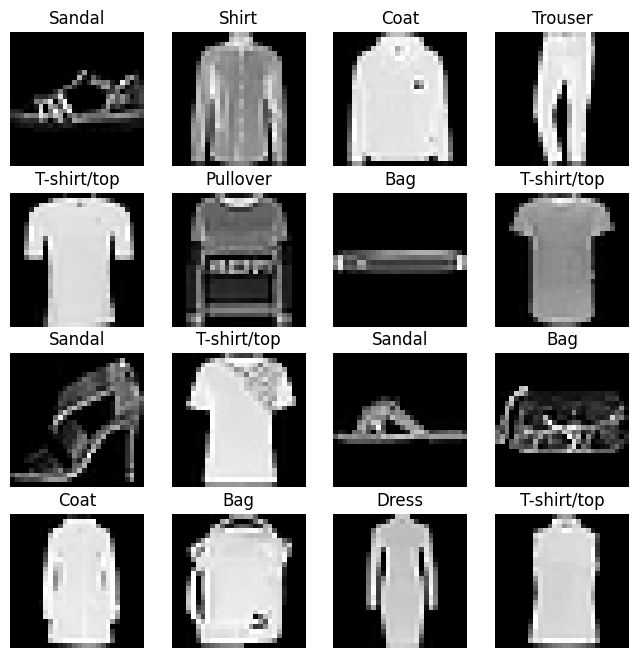

In [9]:
fig = plt.figure(figsize=(8,8))
row, col = 4, 4
for i in range(1, row*col + 1):
  random = torch.randint(0, len(train_data), size=[1]).item()
  img, target = train_data[random]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(classes[target])
  plt.axis(False)

In [10]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
  batch_size=BATCH_SIZE,
  shuffle=True
)
test_dataloader = DataLoader(test_data,
  batch_size=BATCH_SIZE,
  shuffle=False
)

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [14]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.b1 = nn.Sequential(nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.b2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
                                nn.ReLU(),
                                torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.classify = nn.Sequential(nn.Flatten(),
                                  nn.Linear(in_features=hidden_units*7*7, out_features=output_shape))

  def forward(self, x):
    x = self.b1(x)
    x = self.b2(x)
    x = self.classify(x)
    return x

torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1,
    hidden_units=10,
    output_shape=len(classes))
model

FashionMNISTModel(
  (b1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

using cnn layers after exploring this https://poloclub.github.io/cnn-explainer/

In [15]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [20]:
def training(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def testing(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
          y_pred=test_pred.argmax(dim=1)
      )
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [22]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    training(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    testing(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )


Epoch: 0
---------
Train loss: 0.35191 | Train accuracy: 87.34%
Test loss: 0.37468 | Test accuracy: 86.78%

Epoch: 1
---------
Train loss: 0.33949 | Train accuracy: 87.79%
Test loss: 0.36246 | Test accuracy: 86.84%

Epoch: 2
---------
Train loss: 0.32888 | Train accuracy: 88.23%
Test loss: 0.34931 | Test accuracy: 87.31%

Epoch: 3
---------
Train loss: 0.31888 | Train accuracy: 88.63%
Test loss: 0.36987 | Test accuracy: 86.28%

Epoch: 4
---------
Train loss: 0.31050 | Train accuracy: 88.80%
Test loss: 0.33271 | Test accuracy: 88.19%



quite better performance but I found this data simple and the pattern can easily identify using cnn layers because when applied the fully connected layer with out use of cnn it was ended up with 76 % accuracy, now gonna implement the CNN on CIFAR10 dataset excited to see what insights I will get from that.
